# Spatial DFBA Model

This notebook demonstrates a Spatial Dynamic Flux Balance Analysis (DFBA) model, simulating and visualizing biomass concentrations over time in a two-dimensional (2D) field. The model integrates diffusion, advection, and sinking mechanisms to show how these processes influence biomass distributions at each timestep across the grid bins.

**Key components of the notebook:**
- **Initialization**: Setting up the spatial environment with defined bounds, bins, and initial states for molecules and species.
- **Process Simulation**: Using the `SpatialDFBA` class to simulate species growth based on local conditions and kinetic parameters.
- **Diffusion and Advection**: Applying diffusion and advection processes to update molecule concentrations and biomass distributions.
- **Visualization**: Plotting the objective flux and spatial fields to visualize biomass and molecule concentrations over time.

Run the notebook to observe how different species interact and grow in a spatially heterogeneous environment, influenced by diffusion, advection, and sinking mechanisms.


## Imports

In [27]:
import os
import numpy as np
from matplotlib import pyplot as plt
from vivarium.core.engine import Engine
from processes.spatial_dfba import SpatialDFBA
from plots.field import plot_objective_flux, plot_fields_temporal
from IPython.display import display, HTML
import imageio.v2 as imageio
import io
import base64
import imageio
import logging
import warnings

In [32]:
# Configuration
total_time = 200
config = {
    'bounds': [5, 5],  # dimensions of the environment
    'nbins': [2, 2],   # division into bins
    'molecules': ['glucose', 'oxygen'],  # available molecules
    'species_info': [
        {
            'name': 'Alteromonas',
            'model': '../data/Alteromonas_Model.xml',  # Path to FBA model file
            'flux_id_map': {
                'glucose': 'EX_cpd00027_e0',
                'oxygen': 'EX_cpd00007_e0'
            },
            'kinetic_params': {
                'glucose': (0.5, 0.0005),  # Km, Vmax for glucose
                'oxygen': (0.3, 0.0005),   # Km, Vmax for oxygen
            }
        },
        {
            'name': 'ecoli',
            'model': '../data/iECW_1372.xml',  # Path to E. coli model file
            'flux_id_map': {
                'glucose': 'EX_glc__D_e',
                'oxygen': 'EX_o2_e'
            },
            'kinetic_params': {
                'glucose': (0.4, 5),  # Km, Vmax for glucose
                'oxygen': (0.25, 0.6),  # Km, Vmax for oxygen
            }
        }
    ]
}



# Initialize the process
spatial_dfba = SpatialDFBA(config)

# Initial state configuration
initial_state_config = {
    'uniform': {
        'glucose': 2,
        'oxygen': 200.0,
        'species': {
            'ecoli': 0.5,
            'Alteromonas': 0.3
        }
    }
}

# Create the initial state
initial_state = spatial_dfba.initial_state(initial_state_config)

# Create the simulation engine
sim = Engine(
    initial_state=initial_state,
    processes={'fba_process': spatial_dfba},
    topology={'fba_process': {
        'fields': ('fields',),
        'species': ('species',),
        'exchange_fluxes': ('exchange_fluxes',),
        'dimensions': ('dimensions',),
    }}
)

# Run the simulation
sim.update(total_time)

# Get the results
data = sim.emitter.get_timeseries()


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Loaded model for Alteromonas


Loaded model for ecoli

Simulation ID: 23354410-285d-11ef-ae31-ba21c95c07d9
Created: 06/11/2024 at 21:43:15


KeyboardInterrupt: 

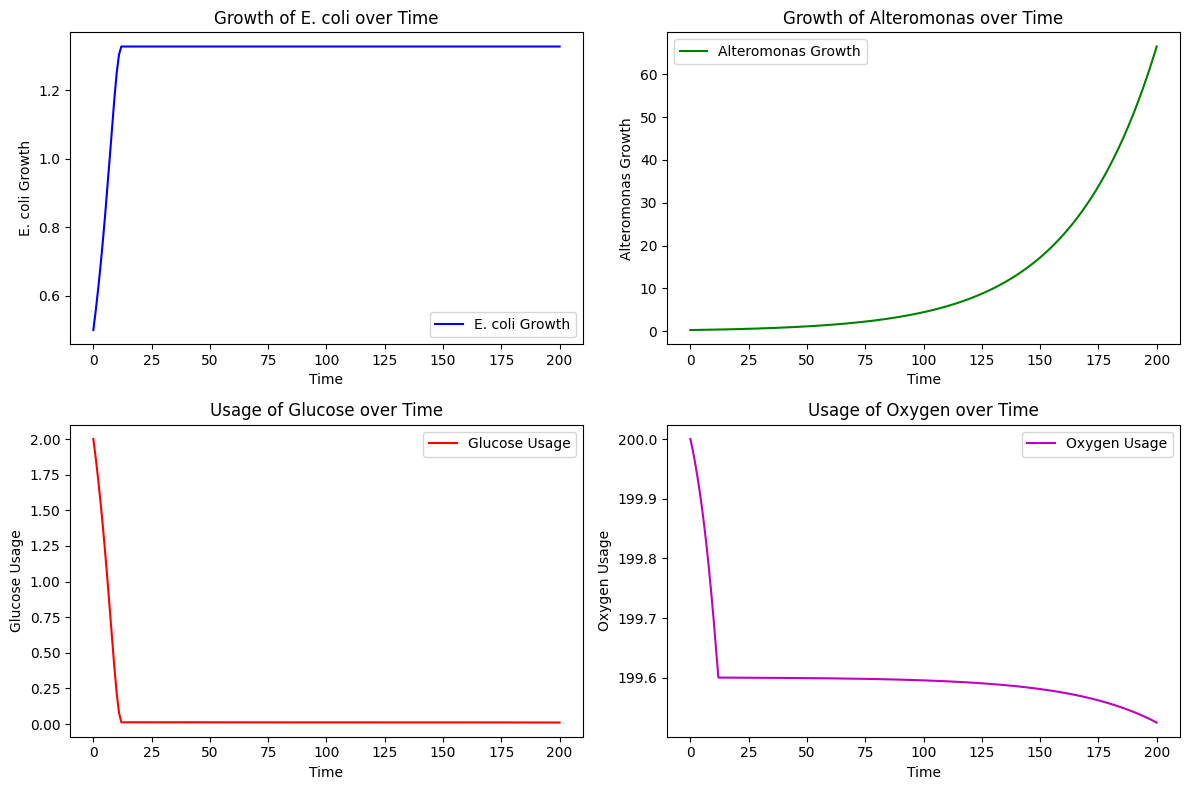

In [3]:
# Extracting the data for plotting
time_points = data["time"]
ecoli_growth = [data["species"]["ecoli"][t][0][0] for t in range(len(time_points))]
alteromonas_growth = [data["species"]["Alteromonas"][t][0][0] for t in range(len(time_points))]
glucose_usage = [data["fields"]["glucose"][t][0][0] for t in range(len(time_points))]
oxygen_usage = [data["fields"]["oxygen"][t][0][0] for t in range(len(time_points))]

# Plotting
plt.figure(figsize=(12, 8))

# Growth of E. coli over time
plt.subplot(2, 2, 1)
plt.plot(time_points, ecoli_growth, label='E. coli Growth', color='b')
plt.xlabel('Time')
plt.ylabel('E. coli Growth')
plt.title('Growth of E. coli over Time')
plt.legend()

# Growth of Alteromonas over time
plt.subplot(2, 2, 2)
plt.plot(time_points, alteromonas_growth, label='Alteromonas Growth', color='g')
plt.xlabel('Time')
plt.ylabel('Alteromonas Growth')
plt.title('Growth of Alteromonas over Time')
plt.legend()

# Usage of glucose over time
plt.subplot(2, 2, 3)
plt.plot(time_points, glucose_usage, label='Glucose Usage', color='r')
plt.xlabel('Time')
plt.ylabel('Glucose Usage')
plt.title('Usage of Glucose over Time')
plt.legend()

# Usage of oxygen over time
plt.subplot(2, 2, 4)
plt.plot(time_points, oxygen_usage, label='Oxygen Usage', color='m')
plt.xlabel('Time')
plt.ylabel('Oxygen Usage')
plt.title('Usage of Oxygen over Time')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
#objective flux of ecoli from time 0 to 200
d=[data["species"]["ecoli"][t][0][0] for t in range(201)]


In [25]:
#data["exchange_fluxes"]['ecoli']["EX_glc__D_e"]

In [4]:
data["exchange_fluxes"]['ecoli']["EX_glc__D_e"]["flux"][30][1][1]

-2.286647781348881

In [9]:
#show the flux of EX_cpd00027_e0 from time 0 to 200
c=[data["exchange_fluxes"]["Alteromonas"]["EX_cpd00027_e0"]["flux"][t][1][1]for t in range(201)]
c

In [12]:
data["exchange_fluxes"]['ecoli']['EX_fe3dhbzs_e'].keys()

dict_keys(['name', 'reaction', 'lower_bound', 'upper_bound', 'flux'])

In [26]:
#data["exchange_fluxes"]['ecoli']['EX_fe3dhbzs_e']

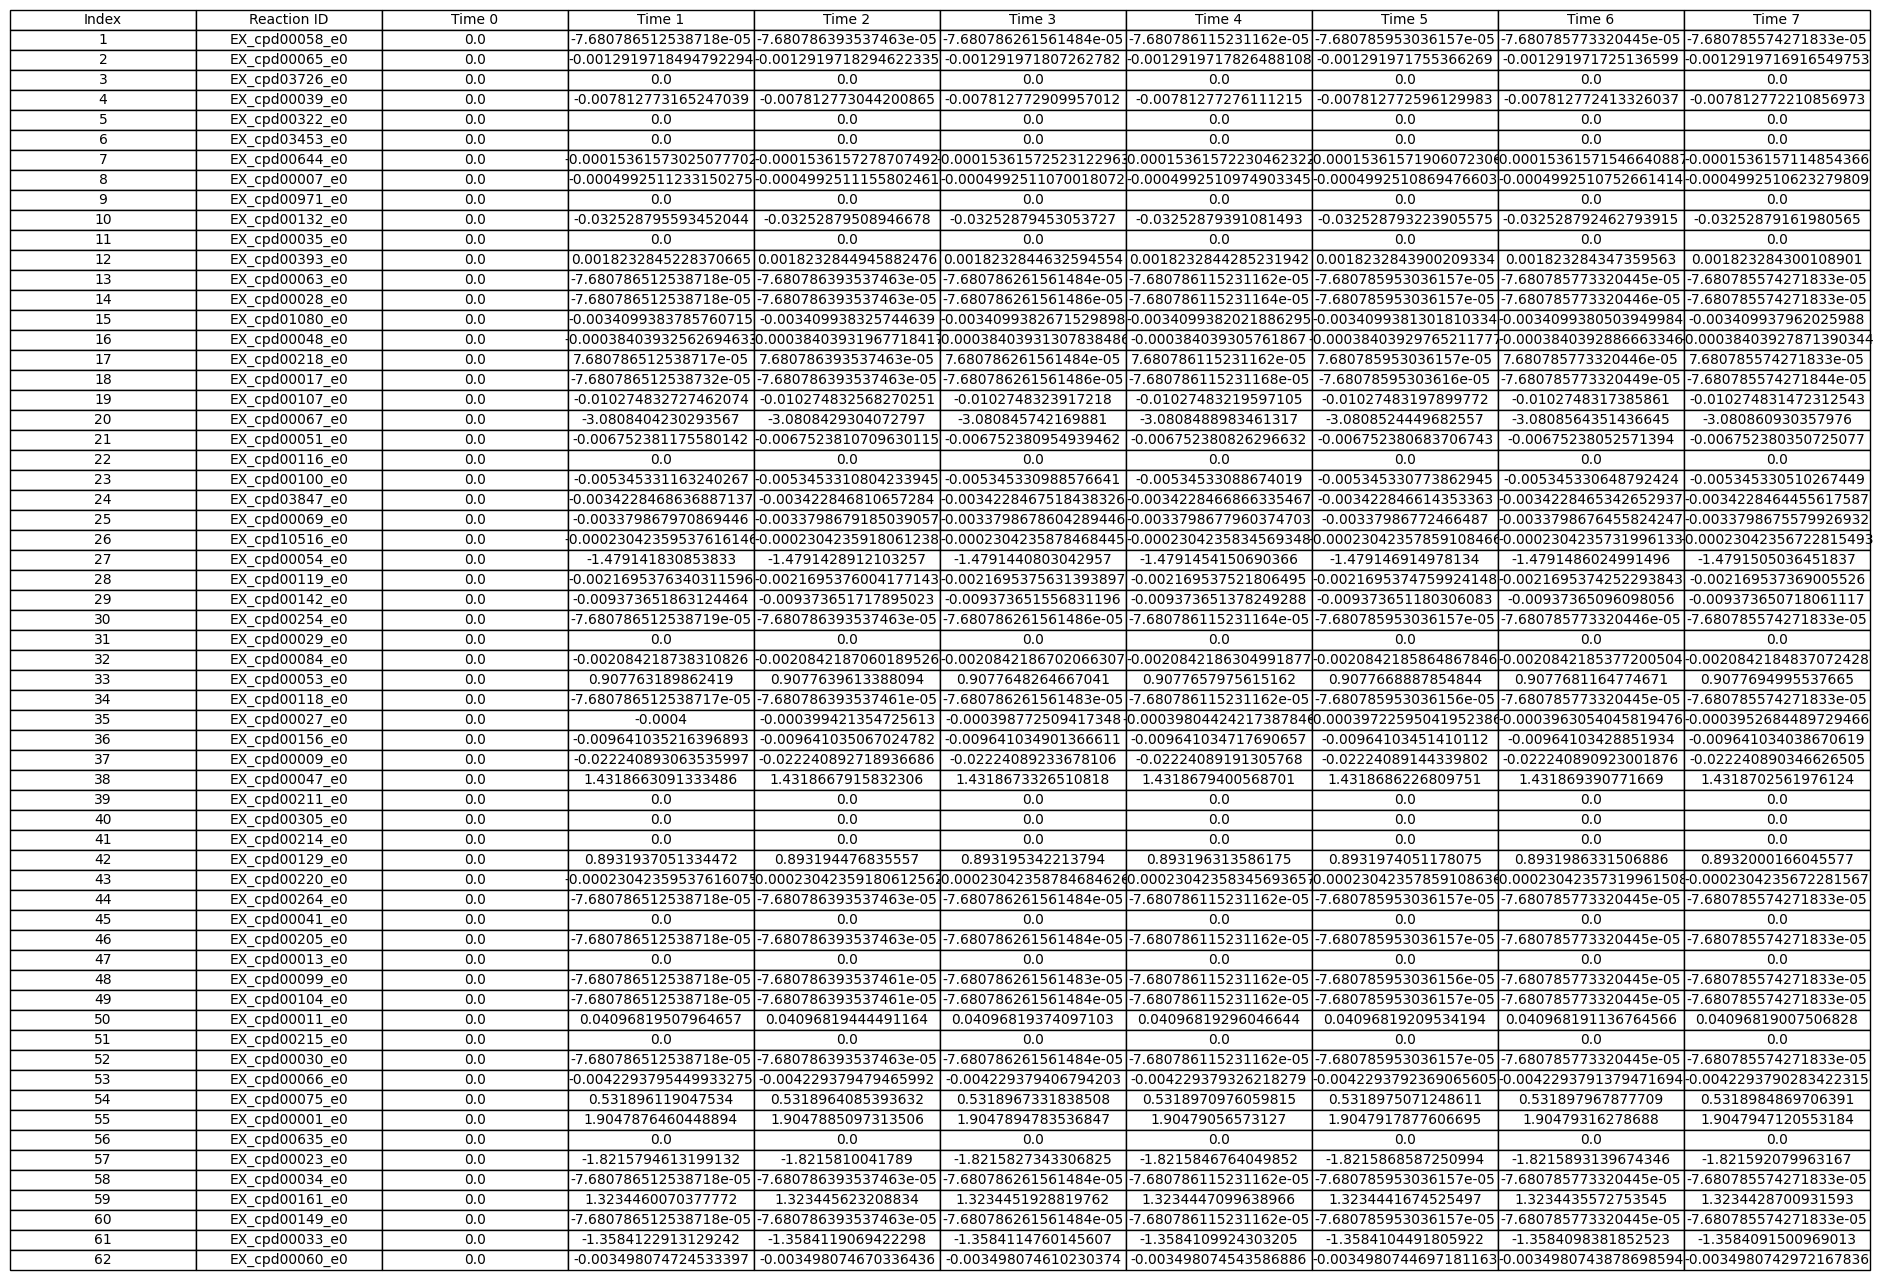

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Define time steps and reaction IDs
time_steps = range(8)
reaction_ids = list(data["exchange_fluxes"]['Alteromonas'].keys())

# Create a dictionary to hold the flux values for each reaction ID
flux_data = {'Index': range(1, len(reaction_ids) + 1), 'Reaction ID': reaction_ids}

for t in time_steps:
    flux_data[f'Time {t}'] = [data["exchange_fluxes"]['Alteromonas'][reaction_id]["flux"][t][0][0] for reaction_id in reaction_ids]

# Create a DataFrame
df = pd.DataFrame(flux_data)

# Display the DataFrame as a table
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()


In [37]:
# Define the reaction ID you want to retrieve information for
reaction_id = 'EX_glc__D_e'

# Retrieve the details for the specified reaction ID
reaction_details = data["exchange_fluxes"]['ecoli'][reaction_id]

# Extract and print the reaction details
reaction_name = reaction_details['name'][0]
reaction_equation = reaction_details['reaction'][0]
lower_bound = reaction_details['lower_bound'][0]
upper_bound = reaction_details['upper_bound'][0]

print(f"Reaction ID: {reaction_id}")
print(f"Reaction Name: {reaction_name}")
print(f"Reaction Equation: {reaction_equation}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")


Reaction ID: EX_glc__D_e
Reaction Name: D-Glucose exchange
Reaction Equation: glc__D_e <=> 
Lower Bound: -10.0
Upper Bound: 1000.0


In [8]:
# Assuming the reaction ID for the exchange reaction you want to track is 'EX_glc__D_e'


# Extract the exchange fluxes for the specified reaction over time
exchange_fluxes = [data["exchange_fluxes"]["ecoli"][reaction_id]['flux'][0][0] for t in range(201)]
exchange_fluxes


NameError: name 'reaction_id' is not defined

In [ ]:
# Calculate the delta (differences) between consecutive elements
delta_d = [((d[i+1] - d[i])/d[i+1]) for i in range (len(d) - 1)]

# Generate the time steps
time_steps = list(range(len(delta_d)))

# Plot the delta per time
plt.figure(figsize=(10, 5))
plt.plot(time_steps, delta_d, marker='o', linestyle='-', color='b')
plt.title('Delta proportional biomass per Time Step')
plt.xlabel('Time Step')
plt.ylabel('Delta')
plt.grid(True)
plt.show()


In [ ]:
# Configuration
total_time = 200
config = {
    'bounds': [5, 5],  # dimensions of the environment
    'nbins': [2, 2],   # division into bins
    'molecules': ['glucose', 'oxygen'],  # available molecules
    'species_info': [
        {
            'name': 'Alteromonas',
            'model': '../data/Alteromonas_Model.xml',  # Path to FBA model file
            'flux_id_map': {
                'glucose': 'EX_cpd00027_e0',
                'oxygen': 'EX_cpd00007_e0'
            },
            'kinetic_params': {
                'glucose': (0.5, 0.0005),  # Km, Vmax for glucose
                'oxygen': (0.3, 0.0005),   # Km, Vmax for oxygen
            }
        },
        {
            'name': 'ecoli',
            'model': '../data/iECW_1372.xml',  # Path to E. coli model file
            'flux_id_map': {
                'glucose': 'EX_glc__D_e',
                'oxygen': 'EX_o2_e'
            },
            'kinetic_params': {
                'glucose': (0.4, 0.6),  # Km, Vmax for glucose
                'oxygen': (0.25, 0.6),  # Km, Vmax for oxygen
            }
        }
    ]
}

# Initialize the process
spatial_dfba = SpatialDFBA(config)

# Initial state configuration
initial_state_config = {
    'uniform': {
        'glucose': 10,
        'oxygen': 200.0,
        'species': {
            'ecoli': 0.5,
            'Alteromonas': 0.3
        }
    }
}

# Create the initial state
initial_state = spatial_dfba.initial_state(initial_state_config)

# Create the simulation engine
sim = Engine(
    initial_state=initial_state,
    processes={'spatial_dfba': spatial_dfba},
    topology={'spatial_dfba': {
        'fields': ('fields',),
        'species': ('species',),
        'dimensions': ('dimensions',),
    }}
)

# Run the simulation
sim.update(total_time)

# Get the results
data = sim.emitter.get_timeseries()


In [ ]:
# Extracting the data for plotting
time_points = data["time"]
ecoli_growth = [data["species"]["ecoli"][t][0][0] for t in range(len(time_points))]
alteromonas_growth = [data["species"]["Alteromonas"][t][0][0] for t in range(len(time_points))]
glucose_usage = [data["fields"]["glucose"][t][0][0] for t in range(len(time_points))]
oxygen_usage = [data["fields"]["oxygen"][t][0][0] for t in range(len(time_points))]

# Plotting
plt.figure(figsize=(12, 8))

# Growth of E. coli over time
plt.subplot(2, 2, 1)
plt.plot(time_points, ecoli_growth, label='E. coli Growth', color='b')
plt.xlabel('Time')
plt.ylabel('E. coli Growth')
plt.title('Growth of E. coli over Time')
plt.legend()

# Growth of Alteromonas over time
plt.subplot(2, 2, 2)
plt.plot(time_points, alteromonas_growth, label='Alteromonas Growth', color='g')
plt.xlabel('Time')
plt.ylabel('Alteromonas Growth')
plt.title('Growth of Alteromonas over Time')
plt.legend()

# Usage of glucose over time
plt.subplot(2, 2, 3)
plt.plot(time_points, glucose_usage, label='Glucose Usage', color='r')
plt.xlabel('Time')
plt.ylabel('Glucose Usage')
plt.title('Usage of Glucose over Time')
plt.legend()

# Usage of oxygen over time
plt.subplot(2, 2, 4)
plt.plot(time_points, oxygen_usage, label='Oxygen Usage', color='m')
plt.xlabel('Time')
plt.ylabel('Oxygen Usage')
plt.title('Usage of Oxygen over Time')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

def plot_objective_flux_to_gif(
        data,
        total_time,
        species_names,
        filename='objective_flux_over_time.gif'
):
    available_time_points = data["time"]
    valid_time_points = list(range(total_time + 1))

    num_species = len(species_names)
    num_times = len(valid_time_points)
    images = []

    # Calculate global min and max for each species and total biomass
    global_min = [np.inf] * (num_species + 1)  # +1 for total biomass
    global_max = [-np.inf] * (num_species + 1)

    # Precompute global min/max for species and total biomass
    for time in valid_time_points:
        time_index = data["time"].index(time)
        total_biomass = np.zeros_like(data["species"][species_names[0]][time_index])

        for j, species_id in enumerate(species_names):
            current_species = data["species"][species_id][time_index]
            total_biomass += current_species
            global_min[j] = min(global_min[j], np.min(current_species))
            global_max[j] = max(global_max[j], np.max(current_species))

        # Update total biomass global min and max
        global_min[-1] = min(global_min[-1], np.min(total_biomass))
        global_max[-1] = max(global_max[-1], np.max(total_biomass))

    # Plotting each species and total biomass for each time
    for time in valid_time_points:
        time_index = data["time"].index(time)
        total_biomass = np.zeros_like(data["species"][species_names[0]][time_index])
        fig, axs = plt.subplots(1, num_species + 1, figsize=(num_species * 5, 5), squeeze=False)

        for j, species_id in enumerate(species_names):
            current_species = data["species"][species_id][time_index]
            total_biomass += current_species
            im = axs[0, j].imshow(current_species, cmap='viridis', vmin=global_min[j], vmax=global_max[j])
            axs[0, j].set_title(species_id)
            axs[0, j].set_xticks([])
            axs[0, j].set_yticks([])
            plt.colorbar(im, ax=axs[0, j], fraction=0.046, pad=0.04)

        # Plot total biomass in the last column
        im = axs[0, -1].imshow(total_biomass, cmap='viridis', vmin=global_min[-1], vmax=global_max[-1])
        axs[0, -1].set_title("Total Biomass")
        axs[0, -1].set_xticks([])
        axs[0, -1].set_yticks([])
        plt.colorbar(im, ax=axs[0, -1], fraction=0.046, pad=0.04)

        # Add the current time as text
        plt.suptitle(f'Time: {time}', fontsize=16)

        plt.tight_layout()
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120)
        buf.seek(0)
        images.append(imageio.imread(buf))
        buf.close()
        plt.close(fig)

    # Create and save the GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.5, loop=0)

    # Optionally display the GIF in a Jupyter notebook
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="Objective Flux Over Time" style="max-width:100%;"/>'))

# Example usage
# Ensure to use time points that exist in your data
plot_objective_flux_to_gif(data, total_time=200, species_names=['ecoli', 'Alteromonas'])

def display_gif(filename):
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    html_str = f'<img src="{data_url}" alt="Fields Over Time" style="max-width:100%;"/><br/>'
    html_str += f'<a href="{data_url}" download="{filename}">Download GIF</a>'
    display(HTML(html_str))

# Display the GIF
# display_gif('objective_flux_over_time.gif')


In [ ]:

# d=[data["species"]["ecoli"][t][0][0] for t in range(201)]
# d

In [ ]:
# f= [data["fields"]["oxygen"][t][0][0] for t in range(201)]
# f

In [ ]:
def plot_molecules_to_gif(
        data,
        total_time,
        molecule_names,
        filename='molecules_over_time.gif'
):
    available_time_points = data["time"]
    valid_time_points = list(range(total_time + 1))

    num_molecules = len(molecule_names)
    num_times = len(valid_time_points)
    images = []

    # Calculate global min and max for each molecule
    global_min = [np.inf] * num_molecules
    global_max = [-np.inf] * num_molecules

    # Precompute global min/max for molecule concentrations
    for time in valid_time_points:
        time_index = data["time"].index(time)

        for j, molecule_id in enumerate(molecule_names):
            current_molecule = data["fields"][molecule_id][time_index]
            global_min[j] = min(global_min[j], np.min(current_molecule))
            global_max[j] = max(global_max[j], np.max(current_molecule))

    # Plotting each molecule concentration for each time
    for time in valid_time_points:
        time_index = data["time"].index(time)
        fig, axs = plt.subplots(1, num_molecules, figsize=(num_molecules * 5, 5), squeeze=False)

        for j, molecule_id in enumerate(molecule_names):
            current_molecule = data["fields"][molecule_id][time_index]
            im = axs[0, j].imshow(current_molecule, cmap='viridis', vmin=global_min[j], vmax=global_max[j])
            axs[0, j].set_title(molecule_id)
            axs[0, j].set_xticks([])
            axs[0, j].set_yticks([])
            plt.colorbar(im, ax=axs[0, j], fraction=0.046, pad=0.04)

        # Add the current time as text
        plt.suptitle(f'Time: {time}', fontsize=16)

        plt.tight_layout()
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120)
        buf.seek(0)
        images.append(imageio.imread(buf))
        buf.close()
        plt.close(fig)

    # Create and save the GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.5, loop=0)

    # Optionally display the GIF in a Jupyter notebook
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="Molecules Over Time" style="max-width:100%;"/>'))

def display_gif(filename):
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    html_str = f'<img src="{data_url}" alt="Fields Over Time" style="max-width:100%;"/><br/>'
    html_str += f'<a href="{data_url}" download="{filename}">Download GIF</a>'
    display(HTML(html_str))

# Example usage
# Ensure to use time points that exist in your data
plot_molecules_to_gif(data, total_time=200, molecule_names=['glucose', 'oxygen'])

# Display the GIF
# display_gif('molecules_over_time.gif')


In [ ]:
def plot_molecules_to_gif(
        data,
        total_time,
        molecule_names,
        filename='molecules_over_time.gif'
):
    available_time_points = data["time"]
    valid_time_points = list(range(total_time + 1))

    num_molecules = len(molecule_names)
    num_times = len(valid_time_points)
    images = []

    # Calculate global min and max for each molecule
    global_min = [np.inf] * num_molecules
    global_max = [-np.inf] * num_molecules

    # Precompute global min/max for molecule concentrations
    for time in valid_time_points:
        time_index = data["time"].index(time)

        for j, molecule_id in enumerate(molecule_names):
            current_molecule = data["fields"][molecule_id][time_index]
            global_min[j] = min(global_min[j], np.min(current_molecule))
            global_max[j] = max(global_max[j], np.max(current_molecule))

    # Plotting each molecule concentration for each time
    for time in valid_time_points:
        time_index = data["time"].index(time)
        fig, axs = plt.subplots(1, num_molecules, figsize=(num_molecules * 5, 5), squeeze=False)

        for j, molecule_id in enumerate(molecule_names):
            current_molecule = data["fields"][molecule_id][time_index]
            im = axs[0, j].imshow(current_molecule, cmap='viridis', vmin=global_min[j], vmax=global_max[j])
            axs[0, j].set_title(molecule_id)
            axs[0, j].set_xticks([])
            axs[0, j].set_yticks([])
            plt.colorbar(im, ax=axs[0, j], fraction=0.046, pad=0.04)

        # Add the current time as text
        plt.suptitle(f'Time: {time}', fontsize=16)

        plt.tight_layout()
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120)
        buf.seek(0)
        images.append(imageio.imread(buf))
        buf.close()
        plt.close(fig)

    # Create and save the GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.5, loop=0)

    # Optionally display the GIF in a Jupyter notebook
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="Molecules Over Time" style="max-width:100%;"/>'))

def display_gif(filename):
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    html_str = f'<img src="{data_url}" alt="Fields Over Time" style="max-width:100%;"/><br/>'
    html_str += f'<a href="{data_url}" download="{filename}">Download GIF</a>'
    display(HTML(html_str))

# Example usage
# Ensure to use time points that exist in your data
plot_molecules_to_gif(data, total_time=200, molecule_names=['glucose', 'oxygen'])

# Display the GIF
# display_gif('molecules_over_time.gif')


In [ ]:
import cobra
from cobra.io import read_sbml_model  # Import to load SBML models

def process_model(sbml_path):
    # Extract the model name from the SBML file path
    model_name = sbml_path.split('/')[-1].replace('.xml', '')

    # Load the model from the SBML file
    model = read_sbml_model(sbml_path)

    # Get the number of exchange fluxes
    exchange_reactions = model.exchanges
    print(exchange_reactions)
    number_of_exchange_fluxes = len(exchange_reactions)

    # Get details of exchange reactions
    exchange_fluxes_details = [
        {
            "ID": reaction.id,
            "Name": reaction.name,
            "Reaction": reaction.reaction,
            "Lower bound": reaction.lower_bound,
            "Upper bound": reaction.upper_bound
        } for reaction in exchange_reactions
    ]
    
    # Get the number of total reactions
    total_reactions = model.reactions
    number_of_total_reactions = len(total_reactions)

    # Get details of all reactions
    total_reactions_details = [
        {
            "ID": reaction.id,
            "Name": reaction.name
        } for reaction in total_reactions
    ]

    # Processed details
    model_details = {
        "model_name": model_name,
        "number_of_exchange_fluxes": number_of_exchange_fluxes,
        "exchange_fluxes_details": exchange_fluxes_details,
        "number_of_total_reactions": number_of_total_reactions,
        "total_reactions_details": total_reactions_details
    }

    return model_details

# Example usage
sbml_path = '../data/Alteromonas_Model.xml'
model_details = process_model(sbml_path)


In [ ]:
exchange_reactions

In [ ]:
import cobra
from cobra.io import read_sbml_model  # Import to load SBML models

def print_exchange_fluxes(sbml_path):
    # Load the model from the SBML file
    model = read_sbml_model(sbml_path)
    
    # Print the exchange fluxes
    exchange_reactions = model.exchanges
# Example usage
sbml_path = '../data/Alteromonas_Model.xml'
print_exchange_fluxes(sbml_path)

In [ ]:
import cobra
from cobra.io import read_sbml_model  # Import to load SBML models

def print_exchange_fluxes(sbml_path):
    # Load the model from the SBML file
    model = read_sbml_model(sbml_path)
    
    # Print the exchange fluxes
    exchange_reactions = solution.exchanges
    #print(exchange_reactions)
    for reaction in exchange_reactions:
        print(f"ID: {reaction.id}, Name: {reaction.name}, Reaction: {reaction.reaction}, "
              f"Lower bound: {reaction.lower_bound}, Upper bound: {reaction.upper_bound}")

# Example usage
sbml_path = '../data/Alteromonas_Model.xml'
print_exchange_fluxes(sbml_path)

In [ ]:





exchange_schema={
    -"default": np array (nbins) ,
    "_value": self.nbins,
    '_updater': 'set',
    '_emit': True,
    "-output": True    #it is just an output port
                }


exchanges: {
    species_id: {reaction_id: for reaction_id in exchange_id}